In [9]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

from xgboost import XGBClassifier

sys.path.append('..')
from text_features.ocean_llama_labeler import OceanLlamaLabeler, OCEAN_DIMS

In [10]:

# 1. Load data

path = kagglehub.dataset_download("ethon0426/lending-club-20072020q1")
file_path = path + "/Loan_status_2007-2020Q3.gzip"

ROW_LIMIT = 10000

read_kwargs = dict(low_memory=False, compression="infer")
if ROW_LIMIT is not None:
    read_kwargs["nrows"] = ROW_LIMIT

df = pd.read_csv(file_path, **read_kwargs)
print(df.shape)
df.head()

(10000, 142)


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,1077430,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2,1077175,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,1076863,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,1075358,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


In [11]:

# 2. Prepare target

TARGET_COL = "loan_status"
keep_status = ["Fully Paid", "Charged Off"]
df = df[df[TARGET_COL].isin(keep_status)].copy()
df["target"] = (df[TARGET_COL] == "Charged Off").astype(int)
df.drop(columns=[TARGET_COL], inplace=True)

print(f"Target distribution: {(df['target']==0).sum()} Paid, {(df['target']==1).sum()} Default")
print(f"Default rate: {df['target'].mean():.2%}")

Target distribution: 8429 Paid, 1571 Default
Default rate: 15.71%


In [12]:

# 3. Clean percentage columns

percent_cols = ["int_rate", "revol_util"]
for col in percent_cols:
    if col in df.columns and df[col].dtype == object:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip("%"), errors="coerce")

In [13]:

# 4. Llama labeling (500 samples)

GROUND_TRUTH_PATH = '../artifacts/ground_truth_llama.csv'

if os.path.exists(GROUND_TRUTH_PATH):
    df_truth = pd.read_csv(GROUND_TRUTH_PATH)
    print(f"Loaded ground truth: {len(df_truth)} samples")
else:
    labeler = OceanLlamaLabeler()
    df_truth = labeler.label_batch(df, sample_size=500, stratified=True, rate_limit_delay=0.5)
    df_truth.to_csv(GROUND_TRUTH_PATH, index=False)

df_truth[[f'{d}_truth' for d in OCEAN_DIMS]].describe()

[Llama Labeler] 分层抽样: 250 违约 + 250 正常

开始使用 Llama 模型标注 OCEAN 特征...
模型: meta-llama/Llama-3.1-8B-Instruct:fireworks-ai


KeyboardInterrupt: 

In [ ]:

# 5. Learn weights (Ridge Regression)

CATEGORICAL_VARS = [
    'grade', 'purpose', 'term', 'home_ownership',
    'emp_length', 'verification_status', 'application_type'
]
CATEGORICAL_VARS = [c for c in CATEGORICAL_VARS if c in df_truth.columns]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_truth[CATEGORICAL_VARS])

y_ocean_truth = df_truth[[f'{d}_truth' for d in OCEAN_DIMS]].copy()
y_ocean_truth.columns = OCEAN_DIMS

weights = {}
for dim in OCEAN_DIMS:
    model = Ridge(alpha=0.17, random_state=42)
    model.fit(X_encoded, y_ocean_truth[dim])
    
    weights[dim] = {
        'intercept': float(model.intercept_),
        'coef': dict(zip(encoder.get_feature_names_out(CATEGORICAL_VARS), model.coef_))
    }
    
    print(f"{dim}: R² = {model.score(X_encoded, y_ocean_truth[dim]):.3f}")

joblib.dump({'weights': weights, 'encoder': encoder}, '../artifacts/ocean_weights_llama.pkl')

openness: R² = 0.300
conscientiousness: R² = 0.876
extraversion: R² = 0.914
agreeableness: R² = 0.588
neuroticism: R² = 0.801


FileNotFoundError: [Errno 2] No such file or directory: '../artifacts/ocean_weights_llama.pkl'

In [14]:

# 6. Top weights per dimension

for dim in OCEAN_DIMS:
    print(f"\n{dim.upper()}:")
    sorted_w = sorted(weights[dim]['coef'].items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    for feat, w in sorted_w:
        print(f"  {feat[:40]:40s} {w:+.4f}")


OPENNESS:
  purpose_small_business                   +0.0981
  purpose_vacation                         +0.0295
  purpose_moving                           -0.0282
  purpose_car                              -0.0272
  purpose_major_purchase                   -0.0216

CONSCIENTIOUSNESS:
  home_ownership_RENT                      -0.2458
  grade_A                                  +0.1699
  home_ownership_MORTGAGE                  +0.1240
  home_ownership_OWN                       +0.1219
  emp_length_< 1 year                      -0.1119

EXTRAVERSION:
  purpose_wedding                          +0.2940
  purpose_vacation                         +0.2746
  purpose_debt_consolidation               -0.1349
  purpose_major_purchase                   -0.0552
  purpose_medical                          -0.0535

AGREEABLENESS:
  purpose_moving                           +0.0398
  purpose_debt_consolidation               -0.0397
  purpose_vacation                         -0.0395
  verification_statu

In [15]:

# 7. Generate OCEAN features for full dataset

X_categorical = df[CATEGORICAL_VARS]
X_encoded_full = encoder.transform(X_categorical)
feature_names = encoder.get_feature_names_out(CATEGORICAL_VARS)

for dim in OCEAN_DIMS:
    intercept = weights[dim]['intercept']
    coef_dict = weights[dim]['coef']
    
    scores = np.full(len(df), intercept)
    for feat_name, weight in coef_dict.items():
        if feat_name in feature_names:
            feat_idx = list(feature_names).index(feat_name)
            scores += X_encoded_full[:, feat_idx] * weight
    
    scores = np.clip(scores, 0.1, 0.9)
    df[dim] = scores

df[OCEAN_DIMS].describe()

,openness,conscientiousness,extraversion,agreeableness,neuroticism
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.354313,0.581026,0.316636,0.459254,0.400418
std,0.027661,0.227190,0.079112,0.038432,0.195847
min,0.307936,0.100000,0.244088,0.335713,0.100000
25%,0.339345,0.376444,0.263907,0.435167,0.244207
50%,0.349016,0.607527,0.283578,0.459476,0.393964
75%,0.360497,0.783894,0.349951,0.485606,0.542919
max,0.498160,0.900000,0.727028,0.558841,0.900000


In [16]:

# 8. OCEAN feature correlations with target

for dim in OCEAN_DIMS:
    corr = df[dim].corr(df['target'])
    auc = roc_auc_score(df['target'], df[dim])
    print(f"{dim:20s} corr={corr:+.3f}  AUC={auc:.3f}")

openness             corr=+0.084  AUC=0.565
conscientiousness    corr=-0.124  AUC=0.395
extraversion         corr=-0.010  AUC=0.534
agreeableness        corr=-0.046  AUC=0.464
neuroticism          corr=+0.166  AUC=0.631


In [19]:

# 9. Prepare features for XGBoost

numeric_features = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util",
    "total_acc"
]
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features_model = [c for c in CATEGORICAL_VARS if c in df.columns]

baseline_features = numeric_features + categorical_features_model
ocean_features = OCEAN_DIMS

print(f"Baseline features: {len(baseline_features)}")
print(f"OCEAN features: {len(ocean_features)}")

Baseline features: 18
OCEAN features: 5


In [20]:

# 10. Preprocessing pipelines

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor_A = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features_model),
    ],
    remainder="drop"
)

preprocessor_B = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ocean", "passthrough", ocean_features),
        ("cat", categorical_transformer, categorical_features_model),
    ],
    remainder="drop"
)

In [21]:

# 11. Train/test split

y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y
)

pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(1, pos)

print(f"Train: {len(X_train)} samples, default rate: {y_train.mean():.2%}")
print(f"Test:  {len(X_test)} samples, default rate: {y_test.mean():.2%}")

Train: 8000 samples, default rate: 15.71%
Test:  2000 samples, default rate: 15.70%


In [22]:

# 12. Model A: Baseline

X_train_A = preprocessor_A.fit_transform(X_train)
X_test_A = preprocessor_A.transform(X_test)

model_A = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="auc",
    verbosity=0
)

model_A.fit(X_train_A, y_train)
y_proba_A = model_A.predict_proba(X_test_A)[:, 1]
y_pred_A = (y_proba_A >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba_A))
print("PR-AUC:", average_precision_score(y_test, y_proba_A))
print(classification_report(y_test, y_pred_A, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_A))

ROC-AUC: 0.6864814017272254
PR-AUC: 0.27326643474135204
              precision    recall  f1-score   support

           0     0.8745    0.8185    0.8456      1686
           1     0.2749    0.3694    0.3152       314

    accuracy                         0.7480      2000
   macro avg     0.5747    0.5940    0.5804      2000
weighted avg     0.7804    0.7480    0.7623      2000

Confusion Matrix:
 [[1380  306]
 [ 198  116]]


In [23]:

# 13. Model B: Baseline + OCEAN

X_train_B = preprocessor_B.fit_transform(X_train)
X_test_B = preprocessor_B.transform(X_test)

model_B = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="auc",
    verbosity=0
)

model_B.fit(X_train_B, y_train)
y_proba_B = model_B.predict_proba(X_test_B)[:, 1]
y_pred_B = (y_proba_B >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba_B))
print("PR-AUC:", average_precision_score(y_test, y_proba_B))
print(classification_report(y_test, y_pred_B, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_B))

ROC-AUC: 0.6875335282695257
PR-AUC: 0.26610542053398795
              precision    recall  f1-score   support

           0     0.8738    0.8333    0.8531      1686
           1     0.2832    0.3535    0.3144       314

    accuracy                         0.7580      2000
   macro avg     0.5785    0.5934    0.5838      2000
weighted avg     0.7810    0.7580    0.7685      2000

Confusion Matrix:
 [[1405  281]
 [ 203  111]]


In [24]:

# 14. A/B Comparison

metrics_A = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_A),
    'PR-AUC': average_precision_score(y_test, y_proba_A)
}

metrics_B = {
    'ROC-AUC': roc_auc_score(y_test, y_proba_B),
    'PR-AUC': average_precision_score(y_test, y_proba_B)
}

comparison = pd.DataFrame({
    'Model A (Baseline)': metrics_A,
    'Model B (+OCEAN)': metrics_B,
    'Delta': {k: metrics_B[k] - metrics_A[k] for k in metrics_A.keys()}
})

comparison

,Model A (Baseline),Model B (+OCEAN),Delta
ROC-AUC,0.686481,0.687534,0.001052
PR-AUC,0.273266,0.266105,-0.007161


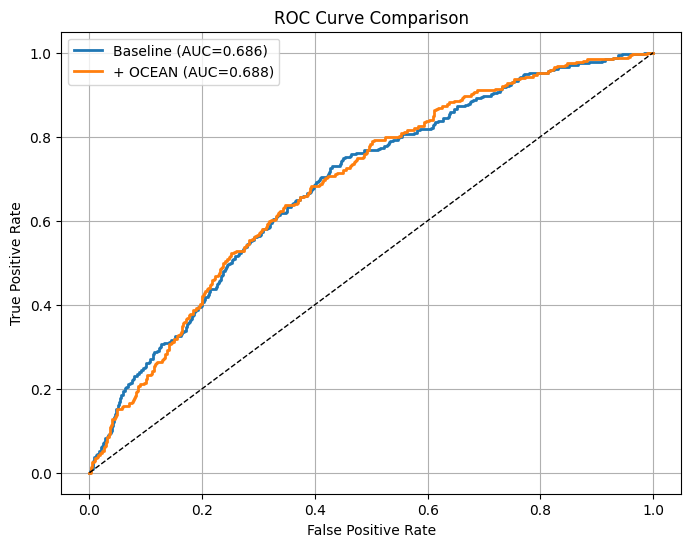

In [25]:

# 15. ROC Curve Comparison

fpr_A, tpr_A, _ = roc_curve(y_test, y_proba_A)
fpr_B, tpr_B, _ = roc_curve(y_test, y_proba_B)

plt.figure(figsize=(8, 6))
plt.plot(fpr_A, tpr_A, label=f"Baseline (AUC={metrics_A['ROC-AUC']:.3f})", linewidth=2)
plt.plot(fpr_B, tpr_B, label=f"+ OCEAN (AUC={metrics_B['ROC-AUC']:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [26]:

# 16. Feature Importances (Model B)

feature_names_B = preprocessor_B.get_feature_names_out()
importances_B = model_B.feature_importances_

importance_df = pd.DataFrame({
    "Feature": feature_names_B,
    "Importance": importances_B
}).sort_values("Importance", ascending=False)

importance_df.head(20)

,Feature,Importance
36,cat__term_ 36 months,0.061791
1,num__int_rate,0.036627
40,cat__home_ownership_RENT,0.028080
37,cat__term_ 60 months,0.027310
30,cat__purpose_moving,0.025011
24,cat__purpose_credit_card,0.023646
31,cat__purpose_other,0.021529
33,cat__purpose_small_business,0.021125
3,num__annual_inc,0.020961
15,ocean__neuroticism,0.020209


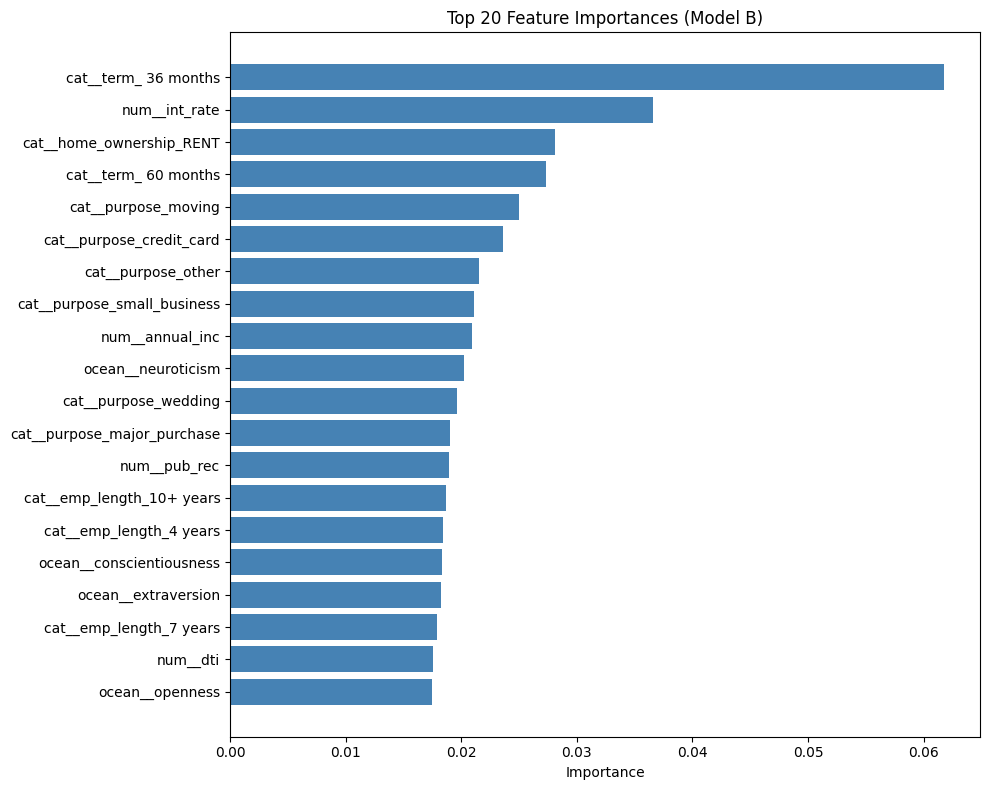

In [27]:

# 17. Plot Top 20 Features

plt.figure(figsize=(10, 8))
top20 = importance_df.head(20).sort_values("Importance")
plt.barh(top20["Feature"], top20["Importance"], color="steelblue")
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Model B)")
plt.tight_layout()
plt.show()

In [28]:

importance_df['rank'] = range(1, len(importance_df) + 1)
ocean_ranks = importance_df[importance_df['Feature'].isin(OCEAN_DIMS)]
ocean_ranks

,Feature,Importance,rank
